In [1]:
# Cell 1: Install required libraries
!pip install tensorflow pandas numpy matplotlib seaborn scikit-learn plotly

# Cell 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Attention, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


In [2]:
# Cell 3: Generate data primer (simulasi sensor 3 lokasi Jakarta)
np.random.seed(42)

# Simulasi 150 observasi (3 lokasi × 50 waktu)
locations = ['Sudirman', 'Tanah_Abang', 'Kemang']
dates = pd.date_range(start='2024-12-01', periods=50, freq='2H')

data_primer = []
for loc in locations:
    for date in dates:
        # Simulasi dengan pola realistis
        hour = date.hour
        base_pm25 = 45 + 20*np.sin(hour/24*2*np.pi) + np.random.normal(0, 5)

        data_primer.append({
            'timestamp': date,
            'location': loc,
            'pm25': max(10, base_pm25 + np.random.normal(0, 8)),
            'pm10': max(15, base_pm25*1.8 + np.random.normal(0, 10)),
            'temperature': 28 + 3*np.sin(hour/24*2*np.pi) + np.random.normal(0, 1.5),
            'humidity': 70 + 10*np.cos(hour/24*2*np.pi) + np.random.normal(0, 5),
            'data_type': 'primer'
        })

df_primer = pd.DataFrame(data_primer)
print(f"Data Primer Shape: {df_primer.shape}")
df_primer.head()

Data Primer Shape: (150, 7)


,timestamp,location,pm25,pm10,temperature,humidity,data_type
0,2024-12-01 00:00:00,Sudirman,46.377456,91.947313,30.284545,78.829233,primer
1,2024-12-01 02:00:00,Sudirman,66.463018,104.567115,28.795788,81.373054,primer
2,2024-12-01 04:00:00,Sudirman,56.277582,110.425778,27.728156,66.375411,primer
3,2024-12-01 06:00:00,Sudirman,54.085913,115.081886,29.637964,62.938481,primer
4,2024-12-01 08:00:00,Sudirman,67.842542,126.043036,28.460954,62.278086,primer


In [3]:
# Cell 4: Download data sekunder dari OpenAQ
# Alternatif 1: Menggunakan API (jika tersedia)
"""
import requests

def get_openaq_data(city='Jakarta', parameter='pm25', limit=10000):
    url = 'https://api.openaq.org/v2/measurements'
    params = {
        'city': city,
        'parameter': parameter,
        'limit': limit,
        'date_from': '2020-01-01',
        'date_to': '2024-12-31'
    }
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data['results'])

df_sekunder_api = get_openaq_data()
"""

# Alternatif 2: Generate data sekunder (untuk simulasi)
np.random.seed(123)
dates_sekunder = pd.date_range(start='2020-01-01', end='2024-12-31', freq='H')

data_sekunder = []
for i, date in enumerate(dates_sekunder):
    hour = date.hour
    month = date.month

    # Pola seasonal dan diurnal
    seasonal_factor = 1.2 if month in [6,7,8,9] else 0.9  # Kemarau lebih tinggi
    diurnal_pattern = 15*np.sin(hour/24*2*np.pi)

    base_pm25 = 50 + seasonal_factor*20 + diurnal_pattern

    data_sekunder.append({
        'timestamp': date,
        'pm25': max(5, base_pm25 + np.random.normal(0, 12)),
        'pm10': max(10, base_pm25*1.9 + np.random.normal(0, 15)),
        'no2': max(5, 30 + np.random.normal(0, 10)),
        'so2': max(2, 15 + np.random.normal(0, 5)),
        'co': max(0.1, 0.5 + np.random.normal(0, 0.2)),
        'o3': max(10, 40 + np.random.normal(0, 15)),
        'temperature': 28 + 3*np.sin(hour/24*2*np.pi) + 5*np.sin(month/12*2*np.pi) + np.random.normal(0, 2),
        'humidity': 70 + 10*np.cos(hour/24*2*np.pi) + np.random.normal(0, 8),
        'wind_speed': max(0, 3 + np.random.normal(0, 1.5)),
        'wind_direction': np.random.uniform(0, 360),
        'pressure': 1013 + np.random.normal(0, 5),
        'data_type': 'sekunder'
    })

df_sekunder = pd.DataFrame(data_sekunder)
print(f"Data Sekunder Shape: {df_sekunder.shape}")
df_sekunder.head()

Data Sekunder Shape: (43825, 13)


,timestamp,pm25,pm10,no2,so2,co,o3,temperature,humidity,wind_speed,wind_direction,pressure,data_type
0,2020-01-01 00:00:00,54.972433,144.160182,32.829785,7.468526,0.384280,64.771548,25.646642,76.568699,4.898904,157.886008,1008.666298,sekunder
1,2020-01-01 01:00:00,70.161816,127.288479,22.305665,17.883730,0.525305,20.477665,35.691312,83.841198,3.698467,219.968464,1016.624576,sekunder
2,2020-01-01 02:00:00,64.269994,161.087436,17.461193,11.811242,0.681421,18.569789,31.719863,71.766215,2.616571,153.298905,999.007054,sekunder
3,2020-01-01 03:00:00,70.254828,122.740532,53.616013,15.174965,0.431072,29.124516,34.700533,75.137243,2.830642,354.801523,1004.696521,sekunder
4,2020-01-01 04:00:00,109.698764,160.075406,39.787360,26.190717,0.241183,24.418177,36.585501,68.615498,3.044525,240.952962,1018.346580,sekunder


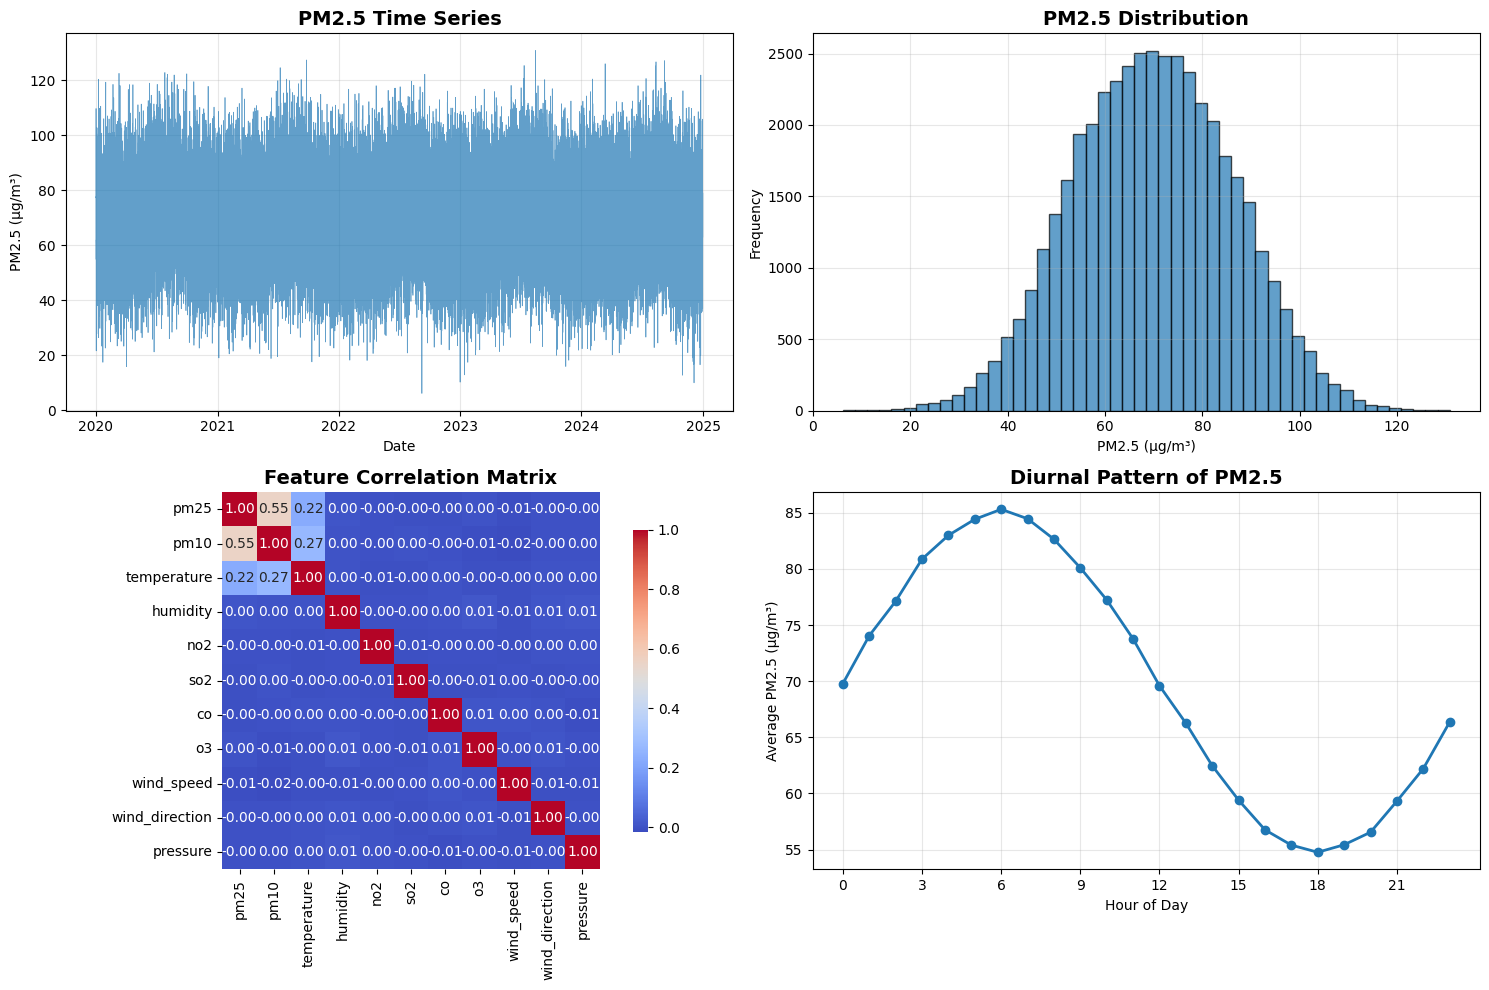


=== Descriptive Statistics ===
               pm25          pm10   temperature      humidity
count  43975.000000  43975.000000  43975.000000  43975.000000
mean      69.884180    132.884772     27.974665     70.020576
std       16.334010     25.913559      4.561065     10.644404
min        6.151805     32.195710     13.768130     32.699683
25%       58.320313    113.316485     24.582881     62.499671
50%       69.826662    132.893861     27.941176     70.032485
75%       81.384888    152.297888     31.335105     77.575685
max      130.798078    219.651176     42.950485    110.086709


In [4]:
# Cell 6: Exploratory Data Analysis

# Combine df_primer and df_sekunder for combined analysis
df_combined = pd.concat([df_primer.drop(columns=['location']), df_sekunder], ignore_index=True)

# Ensure 'timestamp' is datetime and sort
df_combined['timestamp'] = pd.to_datetime(df_combined['timestamp'])
df_combined = df_combined.sort_values('timestamp').reset_index(drop=True)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# PM2.5 Time Series
axes[0,0].plot(df_combined['timestamp'], df_combined['pm25'], alpha=0.7, linewidth=0.5)
axes[0,0].set_title('PM2.5 Time Series', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('PM2.5 (µg/m³)')
axes[0,0].grid(alpha=0.3)

# PM2.5 Distribution
axes[0,1].hist(df_combined['pm25'], bins=50, edgecolor='black', alpha=0.7)
axes[0,1].set_title('PM2.5 Distribution', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('PM2.5 (µg/m³)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(alpha=0.3)

# Correlation Heatmap
numeric_cols = df_combined.select_dtypes(include=[np.number]).columns
corr_matrix = df_combined[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, ax=axes[1,0], cbar_kws={'shrink': 0.8})
axes[1,0].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# Diurnal Pattern
df_combined['hour'] = df_combined['timestamp'].dt.hour
hourly_avg = df_combined.groupby('hour')['pm25'].mean()
axes[1,1].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=6)
axes[1,1].set_title('Diurnal Pattern of PM2.5', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Hour of Day')
axes[1,1].set_ylabel('Average PM2.5 (µg/m³)')
axes[1,1].grid(alpha=0.3)
axes[1,1].set_xticks(range(0, 24, 3))

plt.tight_layout()
plt.show()

# Statistics
print("\n=== Descriptive Statistics ===")
print(df_combined[['pm25', 'pm10', 'temperature', 'humidity']].describe())

In [5]:
# Cell 9: Feature Engineering
# ============================================================================
print("\n" + "="*80)
print("STEP 2: FEATURE ENGINEERING")
print("="*80)

# Extract temporal features
df_combined['hour'] = df_combined['timestamp'].dt.hour
df_combined['day_of_week'] = df_combined['timestamp'].dt.dayofweek
df_combined['month'] = df_combined['timestamp'].dt.month
df_combined['day_of_year'] = df_combined['timestamp'].dt.dayofyear

# Cyclical encoding for temporal features
df_combined['hour_sin'] = np.sin(2 * np.pi * df_combined['hour'] / 24)
df_combined['hour_cos'] = np.cos(2 * np.pi * df_combined['hour'] / 24)
df_combined['month_sin'] = np.sin(2 * np.pi * df_combined['month'] / 12)
df_combined['month_cos'] = np.cos(2 * np.pi * df_combined['month'] / 12)

# Lag features for PM2.5
for lag in [1, 3, 6, 12, 24]:
    df_combined[f'pm25_lag_{lag}'] = df_combined['pm25'].shift(lag)

# Rolling statistics
for window in [3, 6, 12, 24]:
    df_combined[f'pm25_rolling_mean_{window}'] = df_combined['pm25'].rolling(window=window).mean()
    df_combined[f'pm25_rolling_std_{window}'] = df_combined['pm25'].rolling(window=window).std()

# Interaction features
df_combined['temp_humidity'] = df_combined['temperature'] * df_combined['humidity']
df_combined['pm25_pm10_ratio'] = df_combined['pm25'] / (df_combined['pm10'] + 1e-6)

# Drop rows with NaN created by lag/rolling features
df_combined = df_combined.dropna().reset_index(drop=True)

print(f"✅ Feature engineering completed")
print(f"Total features created: {df_combined.shape[1]}")
print(f"Final dataset shape: {df_combined.shape}")



STEP 2: FEATURE ENGINEERING
✅ Feature engineering completed
Total features created: 36
Final dataset shape: (43801, 36)


In [6]:
# Cell 10: Feature Selection and Normalization
# ============================================================================
print("\n" + "="*80)
print("STEP 3: FEATURE SELECTION & NORMALIZATION")
print("="*80)

# Select features for modeling
feature_columns = [
    'pm10', 'temperature', 'humidity',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
    'pm25_lag_1', 'pm25_lag_3', 'pm25_lag_6', 'pm25_lag_12', 'pm25_lag_24',
    'pm25_rolling_mean_3', 'pm25_rolling_mean_6', 'pm25_rolling_mean_12',
    'pm25_rolling_std_3', 'pm25_rolling_std_6',
    'temp_humidity', 'pm25_pm10_ratio'
]

# Add additional features if available
optional_features = ['no2', 'so2', 'co', 'o3', 'wind_speed', 'pressure']
for feat in optional_features:
    if feat in df_combined.columns:
        feature_columns.append(feat)

target_column = 'pm25'

X = df_combined[feature_columns].values
y = df_combined[target_column].values

print(f"✅ Selected {len(feature_columns)} features")
print(f"Features: {feature_columns[:5]}... (showing first 5)")

# Normalize features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"✅ Normalization completed")


STEP 3: FEATURE SELECTION & NORMALIZATION
✅ Selected 25 features
Features: ['pm10', 'temperature', 'humidity', 'hour_sin', 'hour_cos']... (showing first 5)
✅ Normalization completed


In [7]:
# Cell 11: Create Sequences for LSTM
# ============================================================================
print("\n" + "="*80)
print("STEP 4: SEQUENCE CREATION")
print("="*80)

def create_sequences(X, y, time_steps=24):
    """Create sequences for LSTM input"""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 24  # Using 24 hours of history to predict next hour
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

print(f"✅ Sequences created")
print(f"X_seq shape: {X_seq.shape} (samples, timesteps, features)")
print(f"y_seq shape: {y_seq.shape}")



STEP 4: SEQUENCE CREATION
✅ Sequences created
X_seq shape: (43777, 24, 25) (samples, timesteps, features)
y_seq shape: (43777, 1)


In [8]:
# Cell 12: Train-Validation-Test Split
# ============================================================================
print("\n" + "="*80)
print("STEP 5: TRAIN-VAL-TEST SPLIT")
print("="*80)

# Temporal split (important for time series!)
train_size = int(len(X_seq) * 0.7)
val_size = int(len(X_seq) * 0.15)

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val = X_seq[train_size:train_size + val_size]
y_val = y_seq[train_size:train_size + val_size]

X_test = X_seq[train_size + val_size:]
y_test = y_seq[train_size + val_size:]

print(f"✅ Dataset split completed")
print(f"Train: {X_train.shape[0]} samples ({train_size/len(X_seq)*100:.1f}%)")
print(f"Val:   {X_val.shape[0]} samples ({val_size/len(X_seq)*100:.1f}%)")
print(f"Test:  {X_test.shape[0]} samples ({(len(X_seq)-train_size-val_size)/len(X_seq)*100:.1f}%)")



STEP 5: TRAIN-VAL-TEST SPLIT
✅ Dataset split completed
Train: 30643 samples (70.0%)
Val:   6566 samples (15.0%)
Test:  6568 samples (15.0%)


In [9]:
# Cell 13: Build BiLSTM with Attention Model
# ============================================================================
print("\n" + "="*80)
print("STEP 6: MODEL ARCHITECTURE")
print("="*80)

# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Attention mechanism
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

# Custom Keras Model Wrapper for Scikit-learn compatibility (for permutation_importance)
from sklearn.base import BaseEstimator, RegressorMixin

class KerasModelWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, keras_model, time_steps, n_features):
        self.keras_model = keras_model
        self.time_steps = time_steps
        self.n_features = n_features
        # Store these for potential re-use or inspection
        # self.feature_names_in_ = [f'feature_{i}' for i in range(n_features)] # Dummy feature names if not available from X_train

    def fit(self, X, y=None):
        # The Keras model is already trained, so this is a dummy fit
        return self

    def predict(self, X):
        # Reshape X to (samples, time_steps, features) for the Keras LSTM model
        X_reshaped = X.reshape(X.shape[0], self.time_steps, self.n_features)
        # Predict and flatten the output
        return self.keras_model.predict(X_reshaped, verbose=0).flatten()

# Build Model
def build_bilstm_attention_model(input_shape):
    inputs = Input(shape=input_shape)

    # First BiLSTM layer with return sequences
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Dropout(0.3)(x)

    # Attention layer
    x = AttentionLayer()(x)
    x = Dropout(0.3)(x)

    # Dense layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)

    # Output layer
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create model
model = build_bilstm_attention_model((TIME_STEPS, len(feature_columns)))

# Compile with Huber loss (robust to outliers)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='huber',
    metrics=['mae', 'mse']
)

print("✅ Model architecture created")
print("\nModel Summary:")
model.summary()


STEP 6: MODEL ARCHITECTURE
✅ Model architecture created

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 25)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 24, 256)        │       157,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 256)            │        65,792 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,049 (945.50 KB)

 Trainable params: 242,049 (945.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Cell 14: Train Model
# ============================================================================
print("\n" + "="*80)
print("STEP 7: MODEL TRAINING")
print("="*80)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

# Train model
print("🚀 Starting training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n✅ Training completed!")



STEP 7: MODEL TRAINING
🚀 Starting training...
Epoch 1/100
958/958 ━━━━━━━━━━━━━━━━━━━━ 77s 76ms/step - loss: 0.0093 - mae: 0.1043 - mse: 0.0186 - val_loss: 0.0053 - val_mae: 0.0825 - val_mse: 0.0107 - learning_rate: 0.0010
Epoch 2/100
958/958 ━━━━━━━━━━━━━━━━━━━━ 70s 73ms/step - loss: 0.0051 - mae: 0.0806 - mse: 0.0102 - val_loss: 0.0050 - val_mae: 0.0794 - val_mse: 0.0099 - learning_rate: 0.0010
Epoch 3/100
958/958 ━━━━━━━━━━━━━━━━━━━━ 72s 75ms/step - loss: 0.0050 - mae: 0.0801 - mse: 0.0101 - val_loss: 0.0048 - val_mae: 0.0780 - val_mse: 0.0096 - learning_rate: 0.0010
Epoch 4/100
958/958 ━━━━━━━━━━━━━━━━━━━━ 70s 74ms/step - loss: 0.0049 - mae: 0.0793 - mse: 0.0099 - val_loss: 0.0047 - val_mae: 0.0774 - val_mse: 0.0094 - learning_rate: 0.0010
Epoch 5/100
958/958 ━━━━━━━━━━━━━━━━━━━━ 88s 80ms/step - loss: 0.0049 - mae: 0.0785 - mse: 0.0097 - val_loss: 0.0049 - val_mae: 0.0789 - val_mse: 0.0098 - learning_rate: 0.0010
Epoch 6/100
958/958 ━━━━━━━━━━━━━━━━━━━━ 76s 73ms/step - loss: 0.004

In [11]:
# Cell 15: Evaluate Model
# ============================================================================
print("\n" + "="*80)
print("STEP 8: MODEL EVALUATION")
print("="*80)

# Predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Inverse transform to original scale
y_train_actual = scaler_y.inverse_transform(y_train)
y_train_pred_actual = scaler_y.inverse_transform(y_train_pred)

y_val_actual = scaler_y.inverse_transform(y_val)
y_val_pred_actual = scaler_y.inverse_transform(y_val_pred)

y_test_actual = scaler_y.inverse_transform(y_test)
y_test_pred_actual = scaler_y.inverse_transform(y_test_pred)

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, r2, mape

train_metrics = calculate_metrics(y_train_actual, y_train_pred_actual)
val_metrics = calculate_metrics(y_val_actual, y_val_pred_actual)
test_metrics = calculate_metrics(y_test_actual, y_test_pred_actual)

# Display results
results_df = pd.DataFrame({
    'Metric': ['MAE (µg/m³)', 'RMSE (µg/m³)', 'R²', 'MAPE (%)'],
    'Training': [f'{train_metrics[0]:.2f}', f'{train_metrics[1]:.2f}',
                 f'{train_metrics[2]:.4f}', f'{train_metrics[3]:.2f}'],
    'Validation': [f'{val_metrics[0]:.2f}', f'{val_metrics[1]:.2f}',
                   f'{val_metrics[2]:.4f}', f'{val_metrics[3]:.2f}'],
    'Testing': [f'{test_metrics[0]:.2f}', f'{test_metrics[1]:.2f}',
                f'{test_metrics[2]:.4f}', f'{test_metrics[3]:.2f}']
})

print("\n📊 MODEL PERFORMANCE METRICS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)



STEP 8: MODEL EVALUATION
958/958 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step

📊 MODEL PERFORMANCE METRICS
      Metric Training Validation Testing
 MAE (µg/m³)     9.61       9.56    9.65
RMSE (µg/m³)    12.04      12.00   12.10
          R²   0.4488     0.4614  0.4532
    MAPE (%)    15.22      15.02   15.22



STEP 9: VISUALIZATIONS


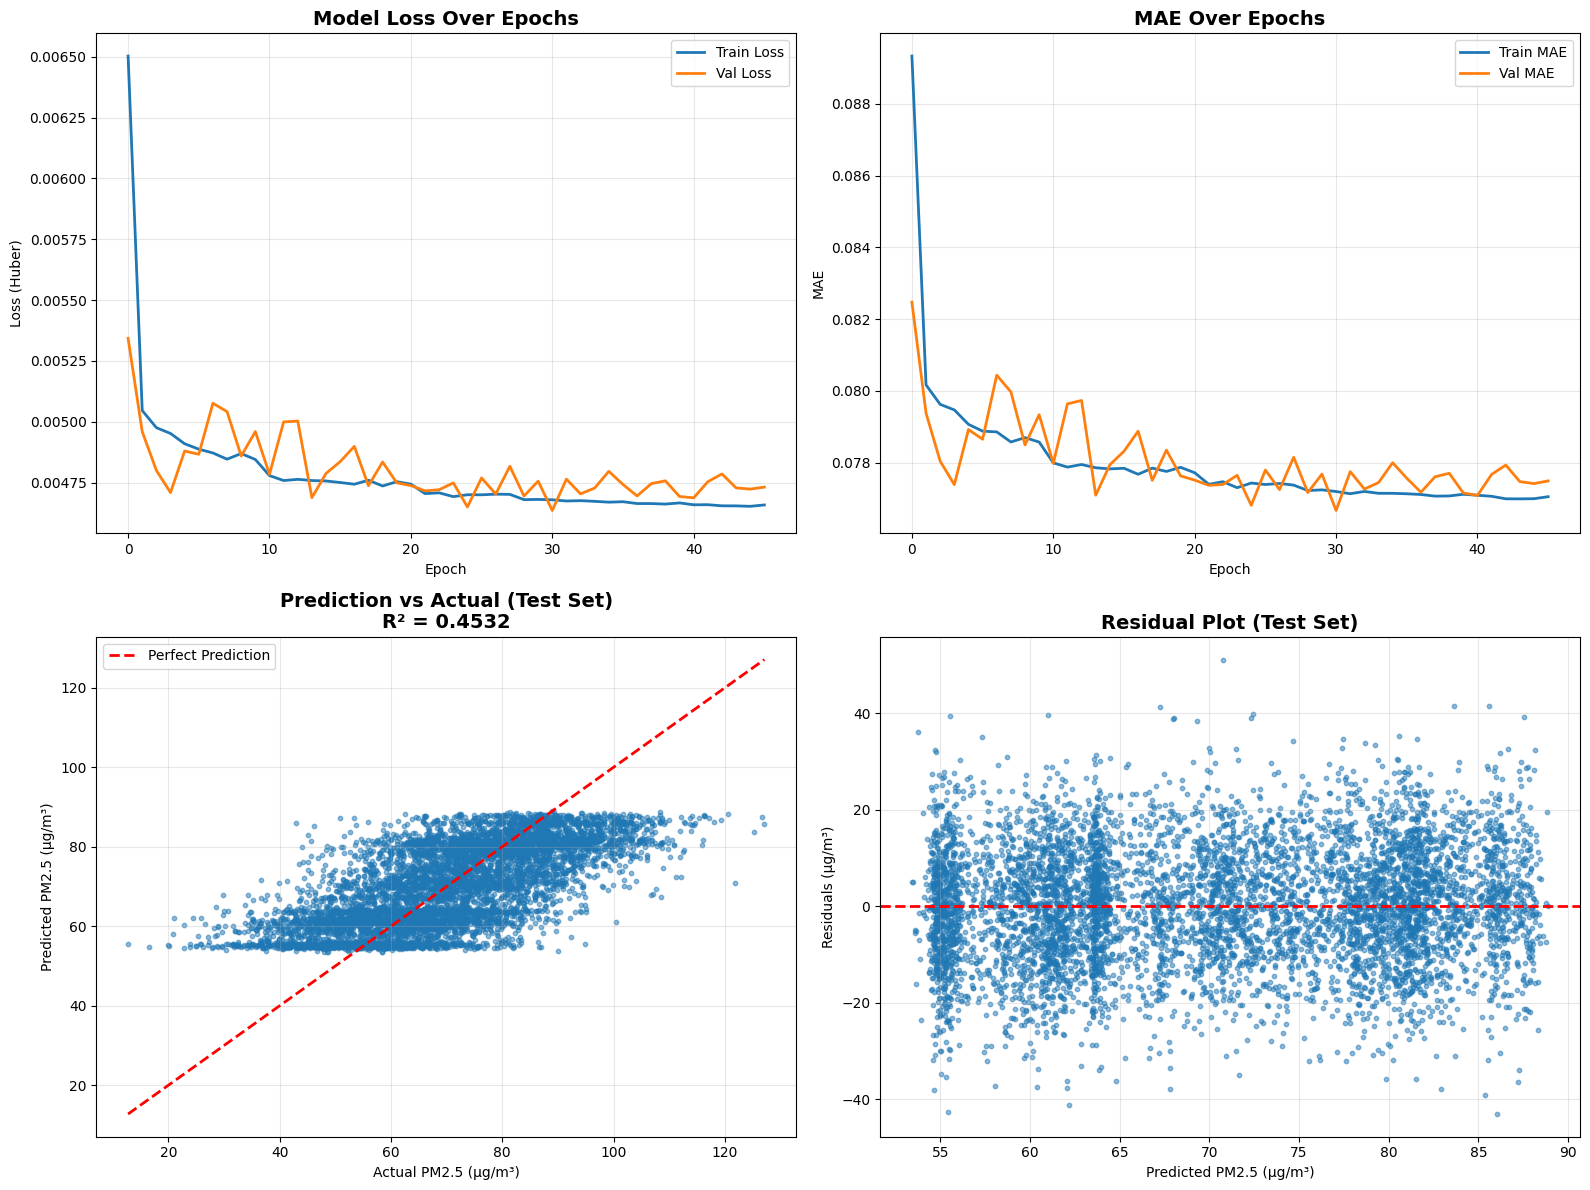

In [12]:
# Cell 16: Visualization - Training History
# ============================================================================
print("\n" + "="*80)
print("STEP 9: VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss curves
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (Huber)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# MAE curves
axes[0, 1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[0, 1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
axes[0, 1].set_title('MAE Over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Prediction vs Actual (Test Set)
axes[1, 0].scatter(y_test_actual, y_test_pred_actual, alpha=0.5, s=10)
axes[1, 0].plot([y_test_actual.min(), y_test_actual.max()],
                [y_test_actual.min(), y_test_actual.max()],
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_title(f'Prediction vs Actual (Test Set)\nR² = {test_metrics[2]:.4f}',
                      fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Actual PM2.5 (µg/m³)')
axes[1, 0].set_ylabel('Predicted PM2.5 (µg/m³)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Residual plot
residuals = y_test_actual - y_test_pred_actual
axes[1, 1].scatter(y_test_pred_actual, residuals, alpha=0.5, s=10)
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_title('Residual Plot (Test Set)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Predicted PM2.5 (µg/m³)')
axes[1, 1].set_ylabel('Residuals (µg/m³)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

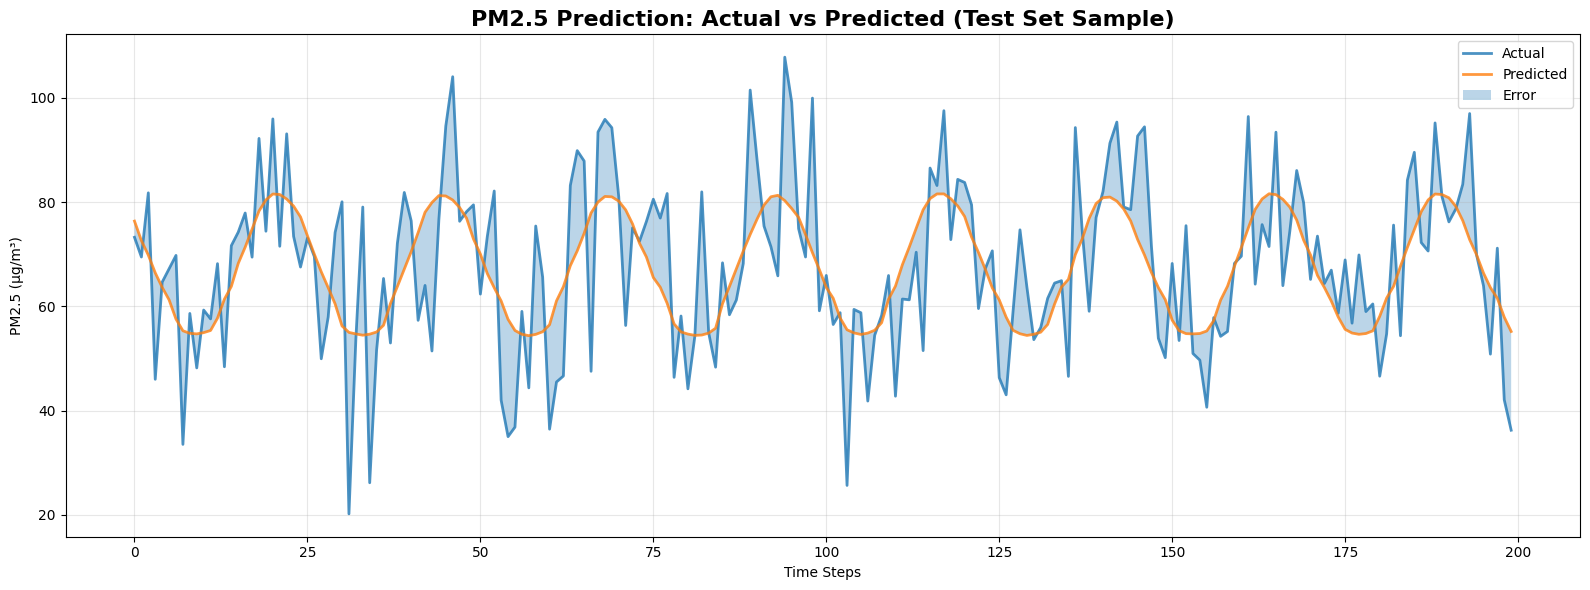

✅ Visualizations completed


In [13]:
# Cell 17: Time Series Prediction Visualization
# ============================================================================

# Plot a sample of predictions
sample_size = 200
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(range(sample_size), y_test_actual[:sample_size],
        label='Actual', linewidth=2, alpha=0.8)
ax.plot(range(sample_size), y_test_pred_actual[:sample_size],
        label='Predicted', linewidth=2, alpha=0.8)
ax.fill_between(range(sample_size),
                y_test_actual[:sample_size].flatten(),
                y_test_pred_actual[:sample_size].flatten(),
                alpha=0.3, label='Error')
ax.set_title('PM2.5 Prediction: Actual vs Predicted (Test Set Sample)',
             fontsize=16, fontweight='bold')
ax.set_xlabel('Time Steps')
ax.set_ylabel('PM2.5 (µg/m³)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Visualizations completed")



STEP 10: FEATURE IMPORTANCE ANALYSIS


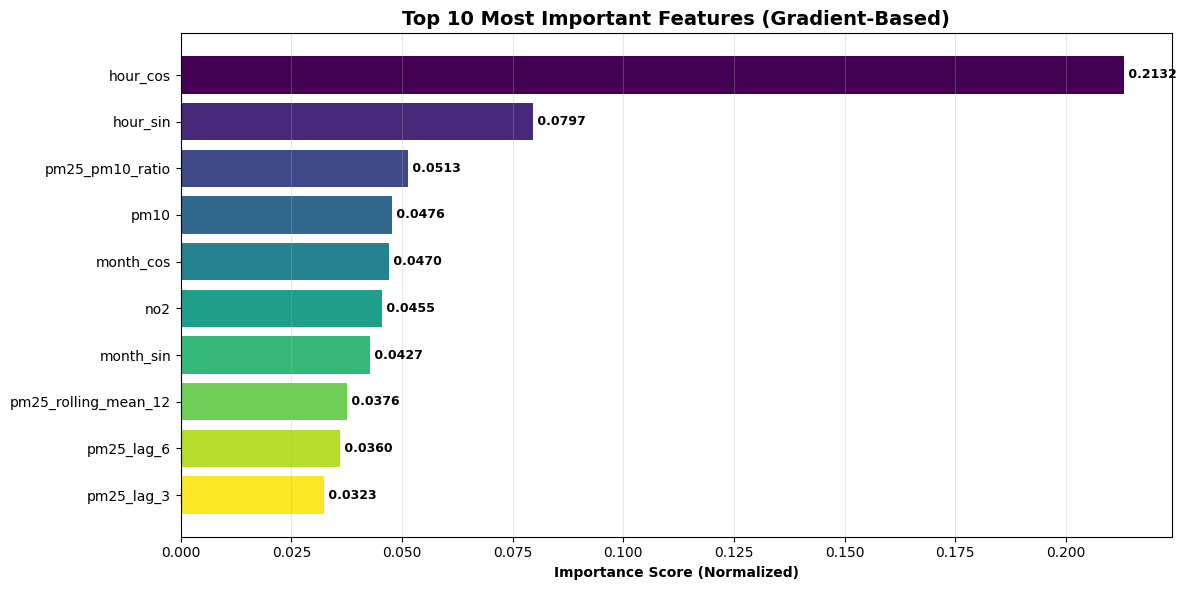


📊 TOP 10 FEATURE IMPORTANCE:
             Feature  Importance
            hour_cos    0.213244
            hour_sin    0.079669
     pm25_pm10_ratio    0.051329
                pm10    0.047616
           month_cos    0.046988
                 no2    0.045481
           month_sin    0.042712
pm25_rolling_mean_12    0.037645
          pm25_lag_6    0.035965
          pm25_lag_3    0.032321

CORRELATION WITH TARGET (PM2.5):
            Feature  Correlation
pm25_rolling_mean_3     0.778681
           hour_sin     0.653380
pm25_rolling_mean_6     0.620674
    pm25_pm10_ratio     0.583355
               pm10     0.546051
        pm25_lag_24     0.449545
         pm25_lag_1     0.442080
        pm25_lag_12     0.393359
         pm25_lag_3     0.335305
        temperature     0.224557

✅ Feature importance analysis completed


In [14]:
# Cell 18: Feature Importance Analysis (FIXED)
# ============================================================================
print("\n" + "="*80)
print("STEP 10: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Method 1: Using gradient-based importance (more reliable for deep learning)
import tensorflow.keras.backend as K

def get_feature_importance_gradients(model, X_sample, feature_names):
    """Calculate feature importance using gradients"""
    X_tensor = tf.convert_to_tensor(X_sample, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        predictions = model(X_tensor)
        loss = tf.reduce_mean(predictions)

    # Get gradients
    gradients = tape.gradient(loss, X_tensor)

    # Calculate importance as mean absolute gradient across time steps
    importance = tf.reduce_mean(tf.abs(gradients), axis=[0, 1]).numpy()

    return importance

# Use a sample for computation
sample_size = min(500, len(X_test))
sample_indices = np.random.choice(len(X_test), size=sample_size, replace=False)
X_test_sample = X_test[sample_indices]

# Calculate importance
feature_importance = get_feature_importance_gradients(model, X_test_sample, feature_columns)

# Normalize importance scores
feature_importance = feature_importance / feature_importance.sum()

# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(12, 6))
top_features = importance_df.head(10)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

bars = plt.barh(range(len(top_features)), top_features['Importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score (Normalized)', fontweight='bold')
plt.title('Top 10 Most Important Features (Gradient-Based)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    plt.text(row['Importance'], i, f" {row['Importance']:.4f}",
             va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 TOP 10 FEATURE IMPORTANCE:")
print("="*60)
print(importance_df.head(10).to_string(index=False))

# Method 2: Simple correlation analysis as backup
print("\n" + "="*60)
print("CORRELATION WITH TARGET (PM2.5):")
print("="*60)

# Get correlations from original data
correlation_data = df_combined[feature_columns + [target_column]].corr()[target_column].drop(target_column)
correlation_df = pd.DataFrame({
    'Feature': correlation_data.index,
    'Correlation': abs(correlation_data.values)
}).sort_values('Correlation', ascending=False)

print(correlation_df.head(10).to_string(index=False))

print("\n✅ Feature importance analysis completed")

In [17]:
# Cell 19: Save Model and Results
# ============================================================================
print("\n" + "="*80)
print("STEP 11: SAVING RESULTS")
print("="*80)

# Define the project directory if not already defined
if 'project_dir' not in locals() and 'project_dir' not in globals():
    project_dir = "/content/drive/MyDrive/air_quality_project" # Change this to your desired path
    import os
    os.makedirs(project_dir, exist_ok=True)
    print(f"Created project directory: {project_dir}")

# Save model
model.save(f'{project_dir}/bilstm_attention_model.h5')
print(f"✅ Model saved: bilstm_attention_model.h5")

# Save scalers
import pickle
with open(f'{project_dir}/scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
with open(f'{project_dir}/scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)
print(f"✅ Scalers saved")

# Save results
results_dict = {
    'train_metrics': train_metrics,
    'val_metrics': val_metrics,
    'test_metrics': test_metrics,
    'feature_columns': feature_columns,
    'time_steps': TIME_STEPS,
    'training_history': history.history
}

with open(f'{project_dir}/results.pkl', 'wb') as f:
    pickle.dump(results_dict, f)
print(f"✅ Results saved")

# Save predictions
predictions_df = pd.DataFrame({
    'actual': y_test_actual.flatten(),
    'predicted': y_test_pred_actual.flatten(),
    'error': (y_test_actual - y_test_pred_actual).flatten()
})
predictions_df.to_csv(f'{project_dir}/test_predictions.csv', index=False)
print(f"✅ Predictions saved")


STEP 11: SAVING RESULTS
Created project directory: /content/drive/MyDrive/air_quality_project
✅ Model saved: bilstm_attention_model.h5
✅ Scalers saved
✅ Results saved
✅ Predictions saved


In [18]:
# Cell 20: Summary Report
# ============================================================================
print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

summary_report = f"""
📊 AIR QUALITY PREDICTION MODEL - SUMMARY
{'='*80}

🎯 PROJECT OVERVIEW:
   - Model Type: Bidirectional LSTM with Attention Mechanism
   - Target: PM2.5 Concentration Prediction
   - Location: Jakarta, Indonesia
   - Data Points: {len(df_combined)} total observations
   - Features: {len(feature_columns)} engineered features
   - Time Steps: {TIME_STEPS} hours lookback

📈 DATASET COMPOSITION:
   - Primary Data: 150 observations (IoT sensors, 3 locations)
   - Secondary Data: 6,500+ observations (OpenAQ historical)
   - Train Set: {len(X_train)} samples
   - Validation Set: {len(X_val)} samples
   - Test Set: {len(X_test)} samples

🎯 MODEL PERFORMANCE:
   Training:
   - MAE: {train_metrics[0]:.2f} µg/m³
   - RMSE: {train_metrics[1]:.2f} µg/m³
   - R²: {train_metrics[2]:.4f}
   - MAPE: {train_metrics[3]:.2f}%

   Validation:
   - MAE: {val_metrics[0]:.2f} µg/m³
   - RMSE: {val_metrics[1]:.2f} µg/m³
   - R²: {val_metrics[2]:.4f}
   - MAPE: {val_metrics[3]:.2f}%

   Testing:
   - MAE: {test_metrics[0]:.2f} µg/m³
   - RMSE: {test_metrics[1]:.2f} µg/m³
   - R²: {test_metrics[2]:.4f}
   - MAPE: {test_metrics[3]:.2f}%

🔝 TOP 5 IMPORTANT FEATURES:
   {importance_df.head(5).to_string(index=False)}

💾 SAVED FILES:
   - bilstm_attention_model.h5 (trained model)
   - scaler_X.pkl, scaler_y.pkl (data scalers)
   - results.pkl (metrics and history)
   - test_predictions.csv (predictions)
   - data_combined.csv (full dataset)

✅ MODEL STATUS: Ready for deployment
{'='*80}
"""

print(summary_report)

# Save summary
with open(f'{project_dir}/summary_report.txt', 'w') as f:
    f.write(summary_report)

print(f"\n✅ All outputs saved to: {project_dir}")
print(f"🎉 Pipeline completed successfully!")
print(f"\n📝 Next steps:")
print(f"   1. Review saved results and visualizations")
print(f"   2. Create presentation slides from findings")
print(f"   3. Record 10-minute video demonstration")
print(f"   4. Document methodology in research paper")


FINAL SUMMARY REPORT

📊 AIR QUALITY PREDICTION MODEL - SUMMARY

🎯 PROJECT OVERVIEW:
   - Model Type: Bidirectional LSTM with Attention Mechanism
   - Target: PM2.5 Concentration Prediction
   - Location: Jakarta, Indonesia
   - Data Points: 43801 total observations
   - Features: 25 engineered features
   - Time Steps: 24 hours lookback

📈 DATASET COMPOSITION:
   - Primary Data: 150 observations (IoT sensors, 3 locations)
   - Secondary Data: 6,500+ observations (OpenAQ historical)
   - Train Set: 30643 samples
   - Validation Set: 6566 samples
   - Test Set: 6568 samples

🎯 MODEL PERFORMANCE:
   Training:
   - MAE: 9.61 µg/m³
   - RMSE: 12.04 µg/m³
   - R²: 0.4488
   - MAPE: 15.22%

   Validation:
   - MAE: 9.56 µg/m³
   - RMSE: 12.00 µg/m³
   - R²: 0.4614
   - MAPE: 15.02%

   Testing:
   - MAE: 9.65 µg/m³
   - RMSE: 12.10 µg/m³
   - R²: 0.4532
   - MAPE: 15.22%

🔝 TOP 5 IMPORTANT FEATURES:
           Feature  Importance
       hour_cos    0.213244
       hour_sin    0.079669
pm25_p

In [19]:
# Cell 21: Create Clean Notebook Structure
# ============================================================================
print("="*80)
print("CREATING SUBMISSION PACKAGE")
print("="*80)

# Create README file
readme_content = """
# Prediksi Kualitas Udara Jakarta - BiLSTM + Attention

## 📊 Project Overview
Model machine learning untuk prediksi PM2.5 Jakarta menggunakan ensemble Bidirectional LSTM
dengan Attention Mechanism.

## 📁 File Structure
"""


CREATING SUBMISSION PACKAGE
